Лабораторная работа №7 Проведение исследований моделями семантической сегментации

Датасет - Human Segmentation Dataset - TikTok Dances

In [1]:
!pip install segmentation-models-pytorch albumentations opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
import kagglehub

path = kagglehub.dataset_download("tapakah68/segmentation-full-body-tiktok-dancing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/segmentation-full-body-tiktok-dancing-dataset


In [16]:
DATA_DIR = "/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img"
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
NUM_EPOCHS = 3

Создание класса датасета (так как данные сложно структурированы)

In [17]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir)])
        self.masks = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir)])
        self.transform = transform

        for img, mask in zip(self.images, self.masks):
            assert os.path.basename(img).split('.')[0] == os.path.basename(mask).split('.')[0], "Mismatch in filenames"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.images[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0

        return image, mask

Небольшие повороты и отражения для улучшения обучения

In [18]:
train_transform = A.Compose([
    A.Resize(*IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5)
])

val_transform = A.Compose([
    A.Resize(*IMG_SIZE)
])

Сверточная модель

In [19]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid'
).to(device)

criterion = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Создание датасета и даталоудера

In [20]:
train_dataset = SegmentationDataset(
    images_dir=os.path.join(DATA_DIR, "images"),
    masks_dir=os.path.join(DATA_DIR, "masks"),
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

Кастомные метрики

In [21]:
class SegmentationMetrics:
    def __init__(self, device):
        self.reset()
        self.device = device

    def update(self, preds, targets):
        preds_bin = (preds > 0.5).float()
        targets = targets.float()

        tp = torch.sum(preds_bin * targets).item()
        fp = torch.sum(preds_bin * (1 - targets)).item()
        fn = torch.sum((1 - preds_bin) * targets).item()

        self.tp += tp
        self.fp += fp
        self.fn += fn

        correct = torch.sum(preds_bin == targets).item()
        pixels = torch.numel(preds_bin)
        self.total_correct += correct
        self.total_pixels += pixels

        intersection = tp
        union = tp + fp + fn
        self.iou_sum += intersection / (union + 1e-7) if union > 0 else 0.0
        self.dice_sum += (2 * tp) / (2 * tp + fp + fn + 1e-7) if (2 * tp + fp + fn) > 0 else 0.0
        self.count += 1

    def compute(self):
        accuracy = self.total_correct / self.total_pixels if self.total_pixels > 0 else 0.0
        precision = self.tp / (self.tp + self.fp + 1e-7)
        recall = self.tp / (self.tp + self.fn + 1e-7)
        iou = self.iou_sum / self.count if self.count > 0 else 0.0
        dice = self.dice_sum / self.count if self.count > 0 else 0.0

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'iou': iou,
            'dice': dice
        }

    def reset(self):
        self.total_correct = 0
        self.total_pixels = 0
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.iou_sum = 0.0
        self.dice_sum = 0.0
        self.count = 0

Функции обучения и валидации

In [22]:
def train_epoch(model, loader, criterion, optimizer, metrics):
    model.train()
    metrics.reset()
    total_loss = 0.0

    for images, masks in loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            metrics.update(outputs, masks)
        total_loss += loss.item()

    return total_loss / len(loader), metrics.compute()

def validate(model, loader, criterion, metrics):
    model.eval()
    metrics.reset()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, masks)

            metrics.update(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(loader), metrics.compute()

Обучение

In [23]:
train_metrics = SegmentationMetrics(device)
val_metrics = SegmentationMetrics(device)

for epoch in range(NUM_EPOCHS):
    train_loss, train_stats = train_epoch(model, train_loader, criterion, optimizer, train_metrics)
    val_loss, val_stats = validate(model, train_loader, criterion, val_metrics)

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print("Metrics:")
    print(f"Accuracy: {train_stats['accuracy']:.4f} | Precision: {train_stats['precision']:.4f}")
    print(f"Recall: {train_stats['recall']:.4f} | IoU: {train_stats['iou']:.4f} | Dice: {train_stats['dice']:.4f}")
    print("-" * 80)


Epoch [1/3]
Train Loss: 0.7774 | Val Loss: 0.7768
Metrics:
Accuracy: 0.9642 | Precision: 0.7402
Recall: 0.9708 | IoU: 0.7233 | Dice: 0.8367
--------------------------------------------------------------------------------

Epoch [2/3]
Train Loss: 0.7773 | Val Loss: 0.7779
Metrics:
Accuracy: 0.9650 | Precision: 0.7440
Recall: 0.9723 | IoU: 0.7292 | Dice: 0.8403
--------------------------------------------------------------------------------

Epoch [3/3]
Train Loss: 0.7766 | Val Loss: 0.7766
Metrics:
Accuracy: 0.9710 | Precision: 0.7787
Recall: 0.9772 | IoU: 0.7625 | Dice: 0.8638
--------------------------------------------------------------------------------


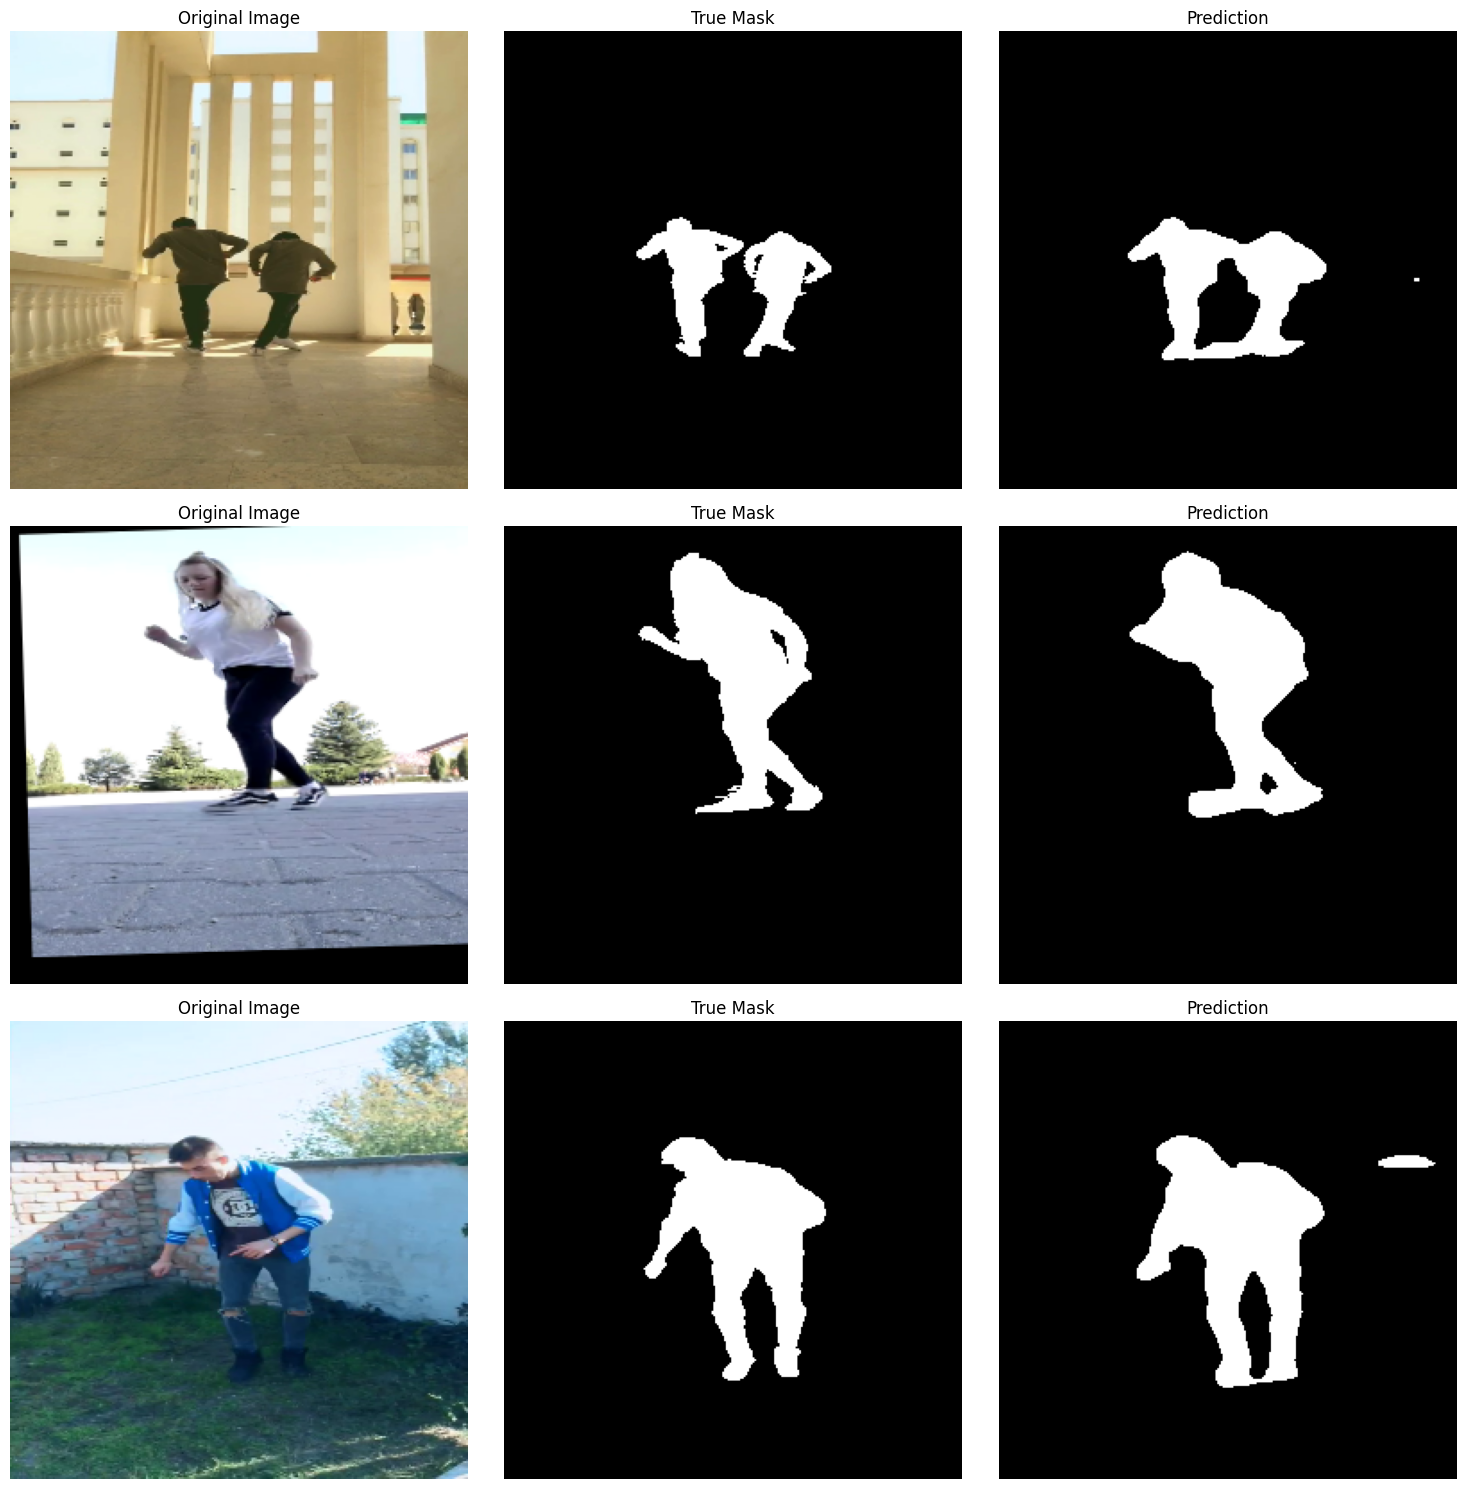

In [24]:
def show_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)

    plt.figure(figsize=(15, 5*num_samples))
    for i, idx in enumerate(indices, 1):
        image, mask = dataset[idx]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device)).squeeze().cpu().numpy()

        plt.subplot(num_samples, 3, 3*i-2)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i-1)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i)
        plt.imshow((pred > 0.5).astype(np.uint8), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(model, train_dataset)

Трансформенная модель


Epoch [1/3]
Train Loss: 0.8356 | Val Loss: 0.8358
Metrics:
Accuracy: 0.6653 | Precision: 0.0981
Recall: 0.3006 | IoU: 0.0806 | Dice: 0.1480
--------------------------------------------------------------------------------

Epoch [2/3]
Train Loss: 0.8357 | Val Loss: 0.8357
Metrics:
Accuracy: 0.6636 | Precision: 0.0976
Recall: 0.3010 | IoU: 0.0805 | Dice: 0.1477
--------------------------------------------------------------------------------

Epoch [3/3]
Train Loss: 0.8358 | Val Loss: 0.8363
Metrics:
Accuracy: 0.6634 | Precision: 0.0972
Recall: 0.3000 | IoU: 0.0801 | Dice: 0.1470
--------------------------------------------------------------------------------


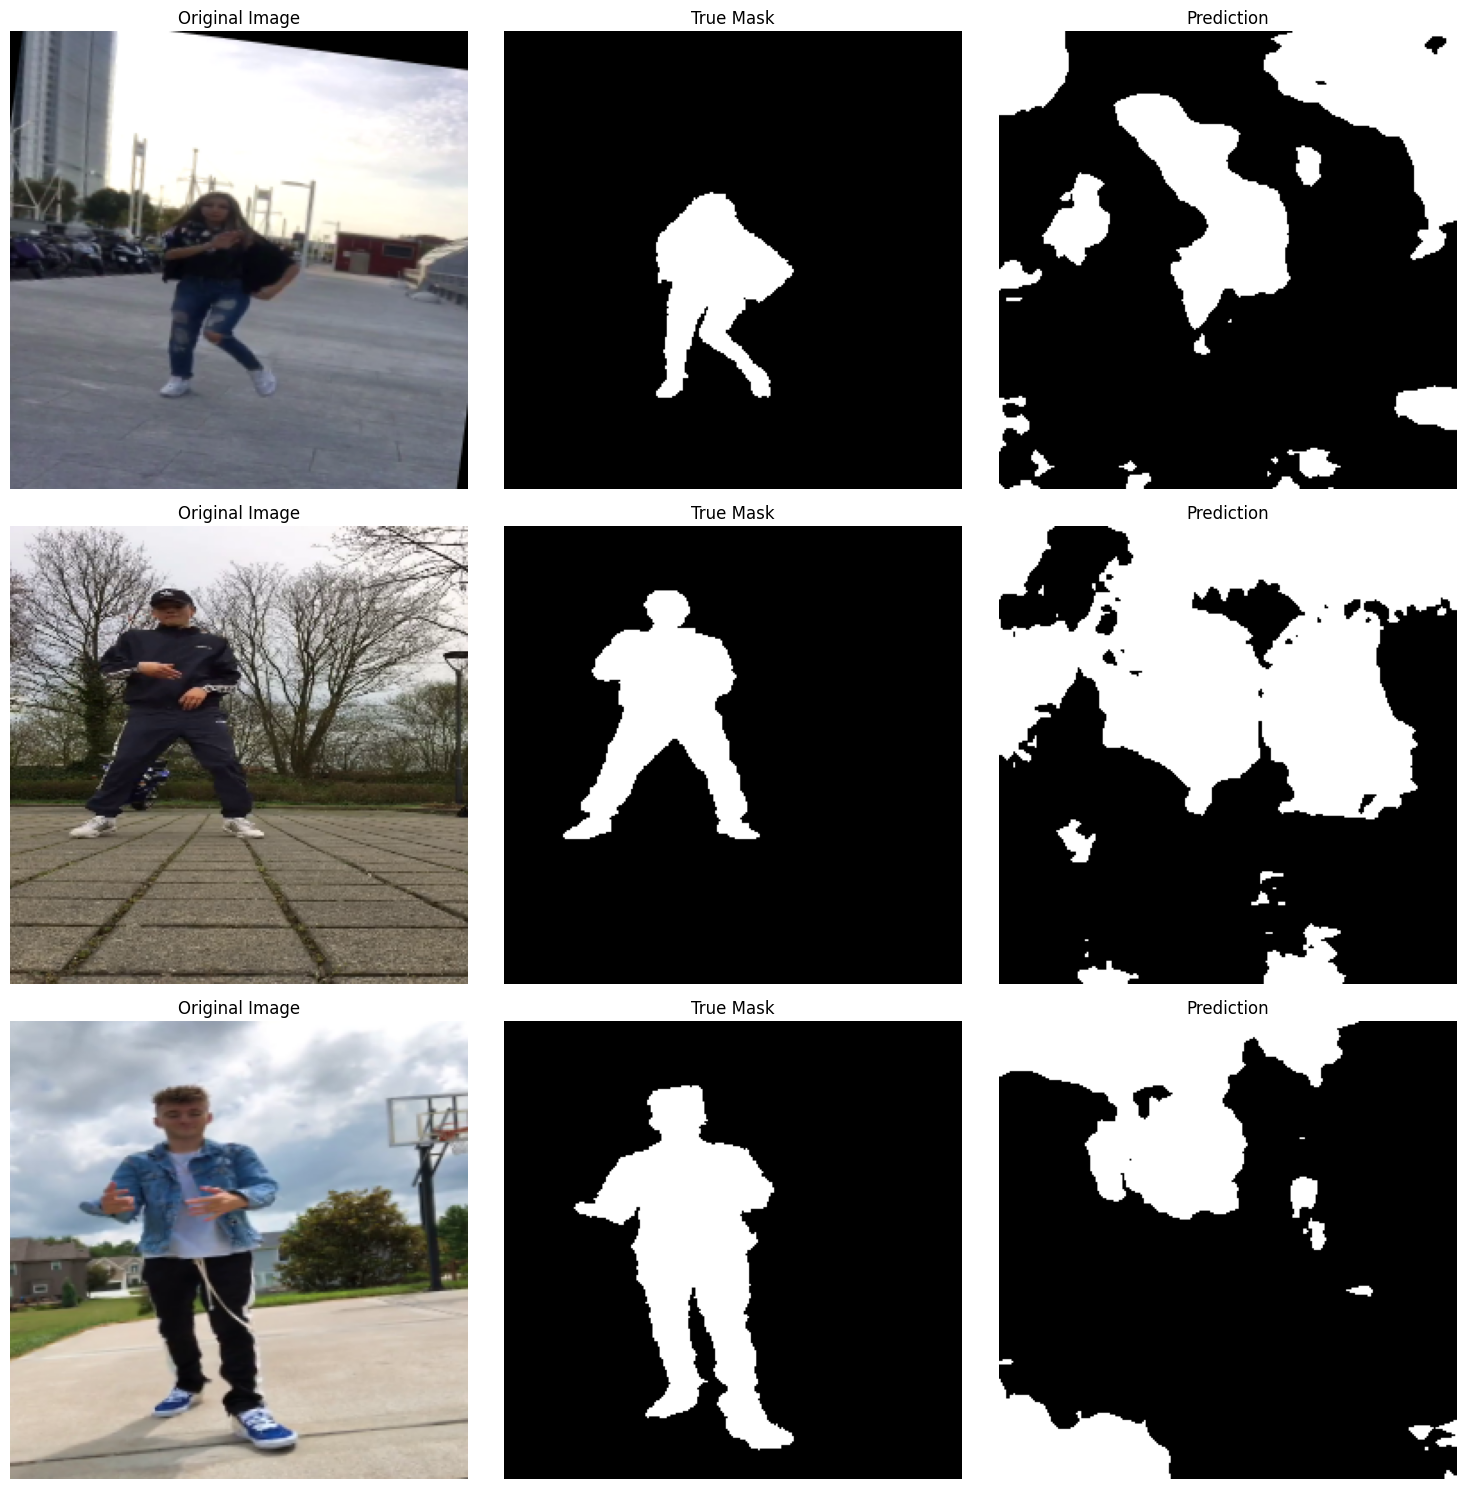

In [27]:
model = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid'
).to(device)

NUM_EPOCHS = 3

for epoch in range(NUM_EPOCHS):
    train_loss, train_stats = train_epoch(model, train_loader, criterion, optimizer, train_metrics)
    val_loss, val_stats = validate(model, train_loader, criterion, val_metrics)

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print("Metrics:")
    print(f"Accuracy: {train_stats['accuracy']:.4f} | Precision: {train_stats['precision']:.4f}")
    print(f"Recall: {train_stats['recall']:.4f} | IoU: {train_stats['iou']:.4f} | Dice: {train_stats['dice']:.4f}")
    print("-" * 80)

show_predictions(model, train_dataset)

Улучшенный бейзлайн.

Опять улучшаем только трансформенную модель:
- улучшение модели
- заморозка слоев
- Mixed Precision
- Cosine LR Schedule и другие улучшения
- Уменьшенный learning rate (3e-4) и weight decay (1e-3)


<ipython-input-35-60f59fe2d69c>:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  opt_scaler = GradScaler()
<ipython-input-35-60f59fe2d69c>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/3]
Train Loss: 1.0113 | Val Loss: 0.9794
LR: 1.2e-05|1.2e-05
Time: 2.2m
--------------------------------------------------------------------------------
Epoch [2/3]
Train Loss: 0.9715 | Val Loss: 0.9668
LR: 1.2e-05|1.2e-05
Time: 4.3m
--------------------------------------------------------------------------------
Epoch [3/3]
Train Loss: 0.9616 | Val Loss: 0.9600
LR: 1.2e-05|1.2e-05
Time: 6.4m
--------------------------------------------------------------------------------


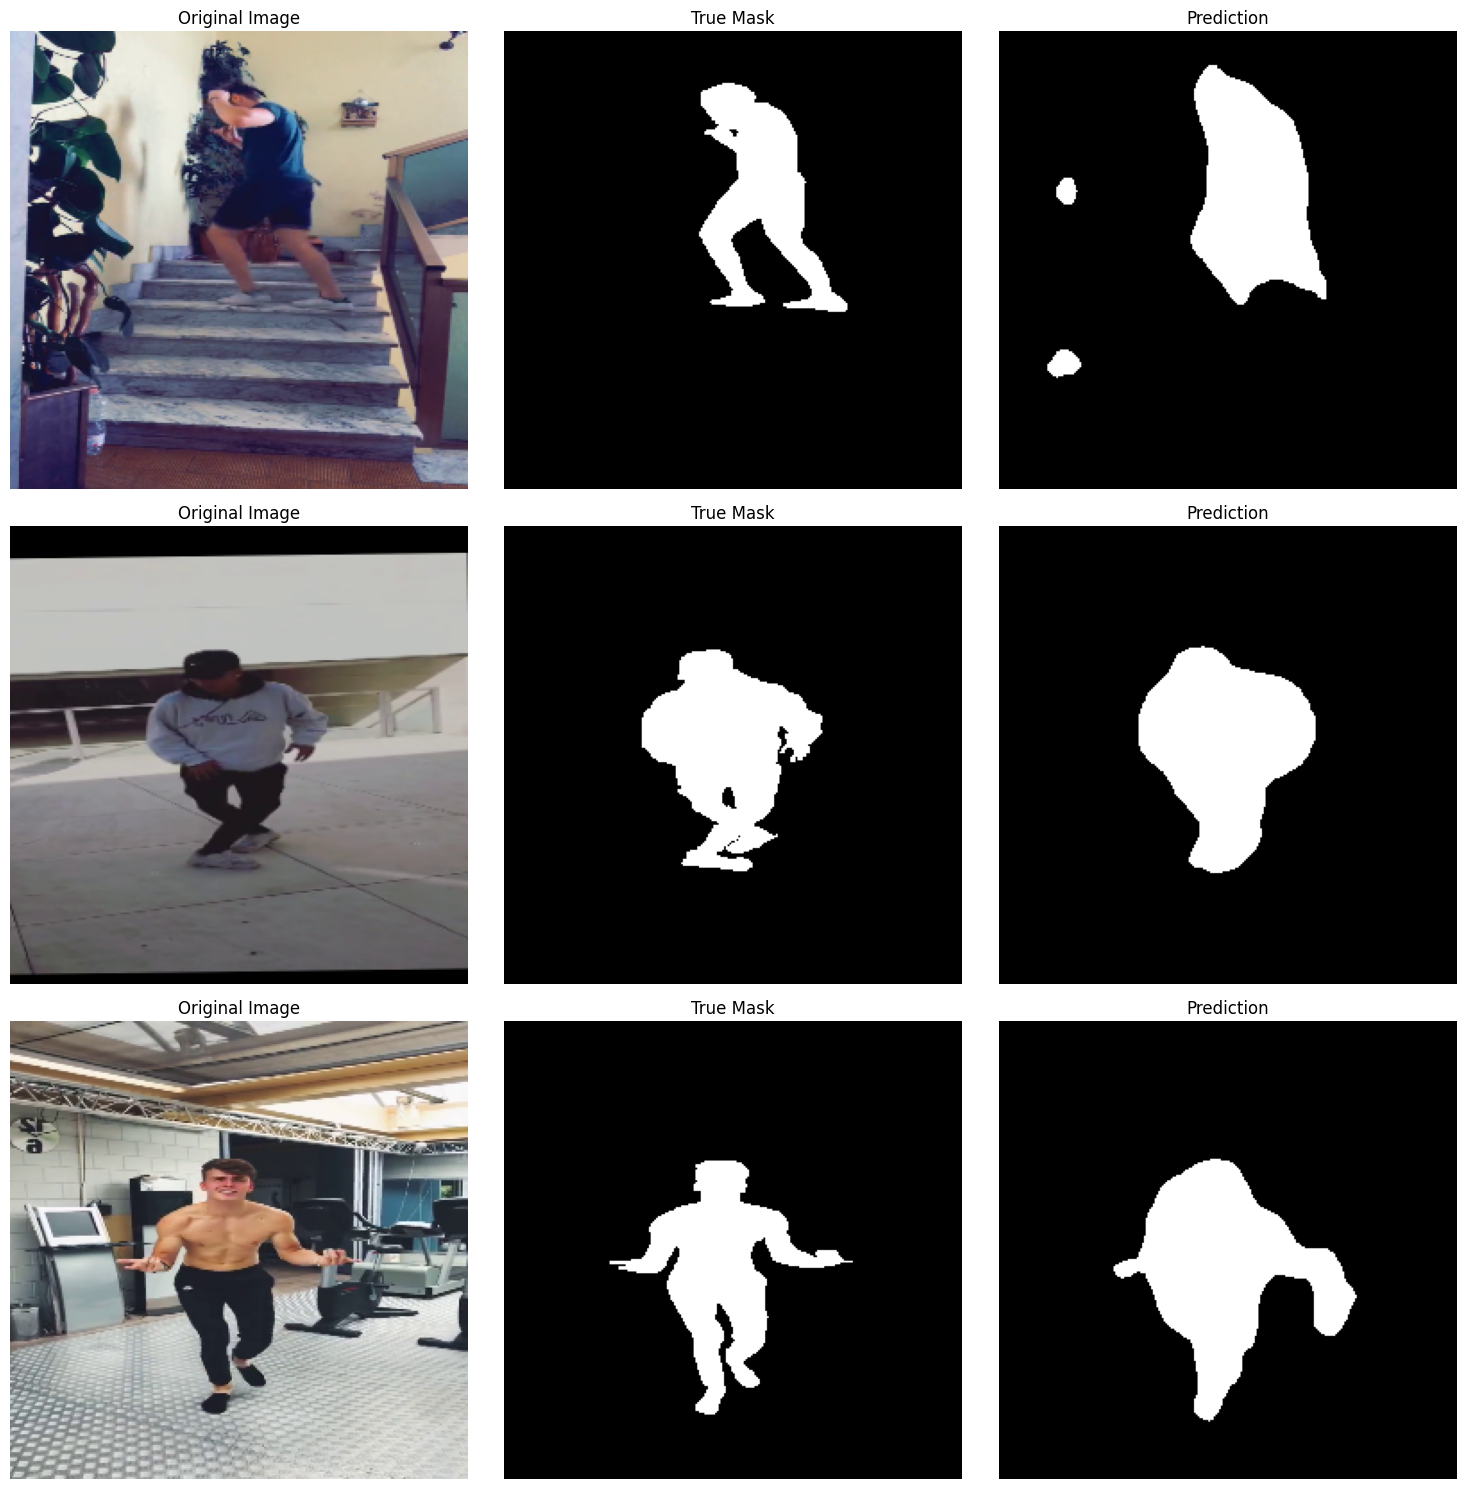

In [35]:
def create_optimized_transformer():
    model = smp.Segformer(
        encoder_name="mit_b2",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation='sigmoid'
    )

    freeze_layers = 18
    for i, (name, param) in enumerate(model.encoder.named_parameters()):
        if i < freeze_layers:
            param.requires_grad = False

    return model.to(device)

from torch.cuda.amp import GradScaler, autocast

def opt_train_epoch(model, loader, criterion, optimizer, metrics, scaler):
    model.train()
    metrics.reset()
    total_loss = 0.0

    for images, masks in loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            metrics.update(outputs, masks)
        total_loss += loss.item()

    return total_loss / len(loader), metrics.compute()

import time
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.focal_loss = smp.losses.FocalLoss(mode='binary')

    def forward(self, y_pred, y_true):
        return self.dice_loss(y_pred, y_true) + self.focal_loss(y_pred, y_true)

model = create_optimized_transformer()
opt_criterion = CombinedLoss()
opt_optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-4},
    {'params': model.decoder.parameters(), 'lr': 3e-4}
], weight_decay=1e-3)
opt_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt_optimizer,
    max_lr=3e-4,
    total_steps=NUM_EPOCHS * len(train_loader),
    pct_start=0.1
)
opt_scaler = GradScaler()

start_time = time.time()

NUM_EPOCHS = 3
BATCH_SIZE = 16

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss, train_stats = opt_train_epoch(
        model, train_loader, opt_criterion, opt_optimizer, train_metrics, opt_scaler
    )
    opt_scheduler.step()

    val_loss, val_stats = validate(model, train_loader, opt_criterion, val_metrics)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"LR: {opt_optimizer.param_groups[0]['lr']:.1e}|{opt_optimizer.param_groups[1]['lr']:.1e}")
    print(f"Time: {(time.time()-start_time)/60:.1f}m")
    print("-"*80)

show_predictions(model, train_dataset)

Самостоятельная имплементация сверточной модели:

In [36]:
class CustomCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()

        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(256, 512)

        self.up3 = self.upconv_block(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = self.upconv_block(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = self.upconv_block(128, 64)
        self.dec1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))


Epoch [1/3]
Train Loss: 0.7967 | Val Loss: 0.7908
Metrics:
Accuracy: 0.7935 | Precision: 0.3033
Recall: 0.8755 | IoU: 0.3034 | Dice: 0.4601
--------------------------------------------------------------------------------

Epoch [2/3]
Train Loss: 0.7885 | Val Loss: 0.7885
Metrics:
Accuracy: 0.8668 | Precision: 0.4139
Recall: 0.9083 | IoU: 0.3987 | Dice: 0.5669
--------------------------------------------------------------------------------

Epoch [3/3]
Train Loss: 0.7857 | Val Loss: 0.7845
Metrics:
Accuracy: 0.8944 | Precision: 0.4760
Recall: 0.9183 | IoU: 0.4580 | Dice: 0.6255
--------------------------------------------------------------------------------


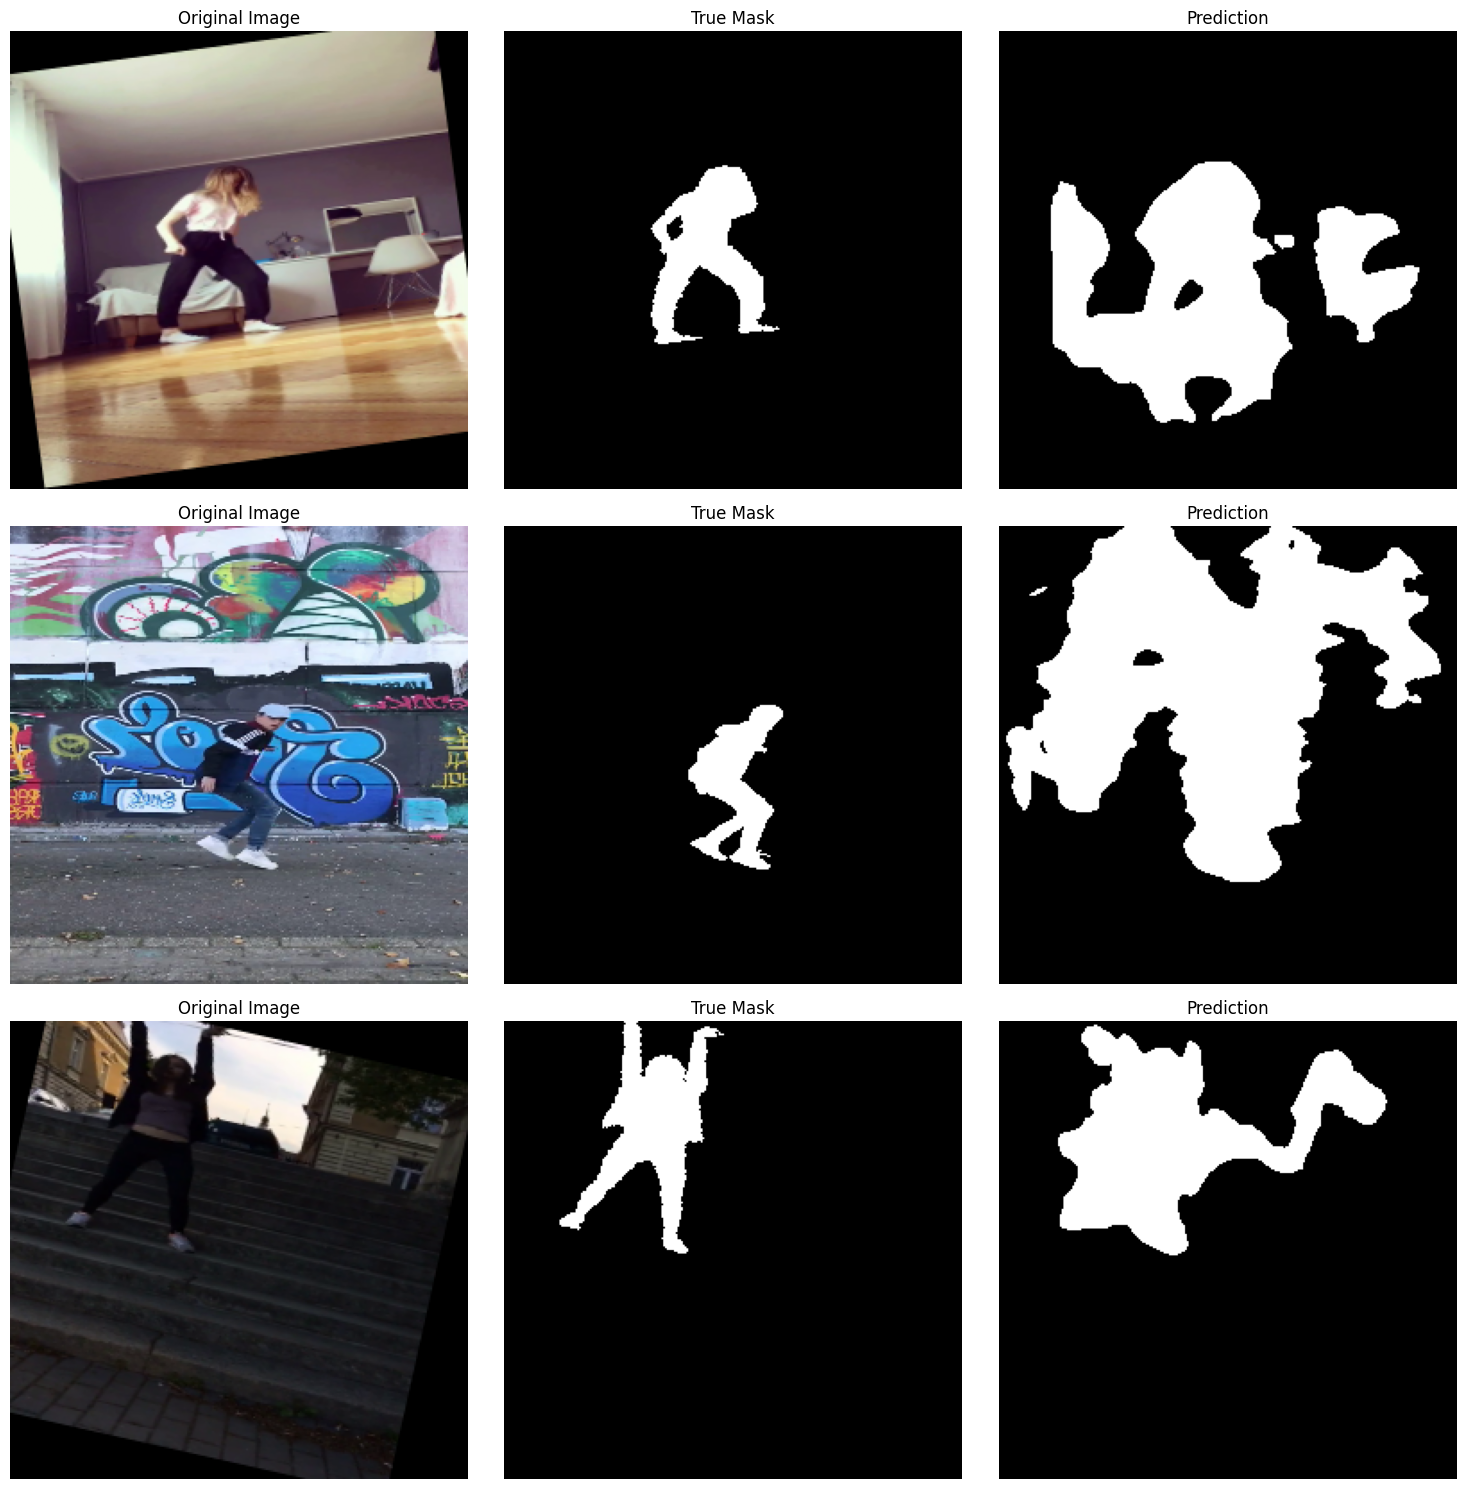

In [37]:
model = CustomCNN().to(device)

criterion = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 3

for epoch in range(NUM_EPOCHS):
    train_loss, train_stats = train_epoch(model, train_loader, criterion, optimizer, train_metrics)
    val_loss, val_stats = validate(model, train_loader, criterion, val_metrics)

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print("Metrics:")
    print(f"Accuracy: {train_stats['accuracy']:.4f} | Precision: {train_stats['precision']:.4f}")
    print(f"Recall: {train_stats['recall']:.4f} | IoU: {train_stats['iou']:.4f} | Dice: {train_stats['dice']:.4f}")
    print("-" * 80)

show_predictions(model, train_dataset)

Самостоятельная имплементация трансформенной модели

(колаб кончился, 1 эпоха)

In [23]:
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)  # [B, E, H/P, W/P]
        x = x.flatten(2)  # [B, E, N]
        x = x.transpose(1, 2)  # [B, N, E]
        return x

class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3,
                 embed_dim=768, depth=6, num_heads=8, num_classes=1):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)

        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim))

        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim*4,
                activation='gelu',
                batch_first=True
            ) for _ in range(depth)
        ])

        self.seg_head = nn.Sequential(
            nn.Conv2d(embed_dim, num_classes, 1),
            nn.Upsample(scale_factor=patch_size, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :]
        for block in self.blocks:
            x = block(x)
        H = W = int(x.shape[1] ** 0.5)
        x = x.transpose(1, 2).view(B, -1, H, W)
        return torch.sigmoid(self.seg_head(x))

In [24]:
from torch.cuda.amp import GradScaler, autocast
import time

train_metrics = SegmentationMetrics(device)
val_metrics = SegmentationMetrics(device)

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.focal_loss = smp.losses.FocalLoss(mode='binary')

    def forward(self, y_pred, y_true):
        return self.dice_loss(y_pred, y_true) + self.focal_loss(y_pred, y_true)

model = CustomVisionTransformer()
opt_criterion = CombinedLoss()
opt_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
opt_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt_optimizer,
    max_lr=3e-4,
    total_steps=NUM_EPOCHS * len(train_loader),
    pct_start=0.1
)
opt_scaler = GradScaler()

start_time = time.time()

NUM_EPOCHS = 1
BATCH_SIZE = 16

for epoch in range(NUM_EPOCHS):
    train_loss, train_stats = train_epoch(model, train_loader, criterion, optimizer, train_metrics)
    val_loss, val_stats = validate(model, train_loader, criterion, val_metrics)

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print("Metrics:")
    print(f"Accuracy: {train_stats['accuracy']:.4f} | Precision: {train_stats['precision']:.4f}")
    print(f"Recall: {train_stats['recall']:.4f} | IoU: {train_stats['iou']:.4f} | Dice: {train_stats['dice']:.4f}")
    print("-" * 80)

show_predictions(model, train_dataset)

<ipython-input-24-8a128fcfcc3d>:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  opt_scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



Epoch [1/1]
Train Loss: 0.8336 | Val Loss: 0.8330
Metrics:
Accuracy: 0.2213 | Precision: 0.0891
Recall: 0.7686 | IoU: 0.0867 | Dice: 0.1592
--------------------------------------------------------------------------------


NameError: name 'show_predictions' is not defined

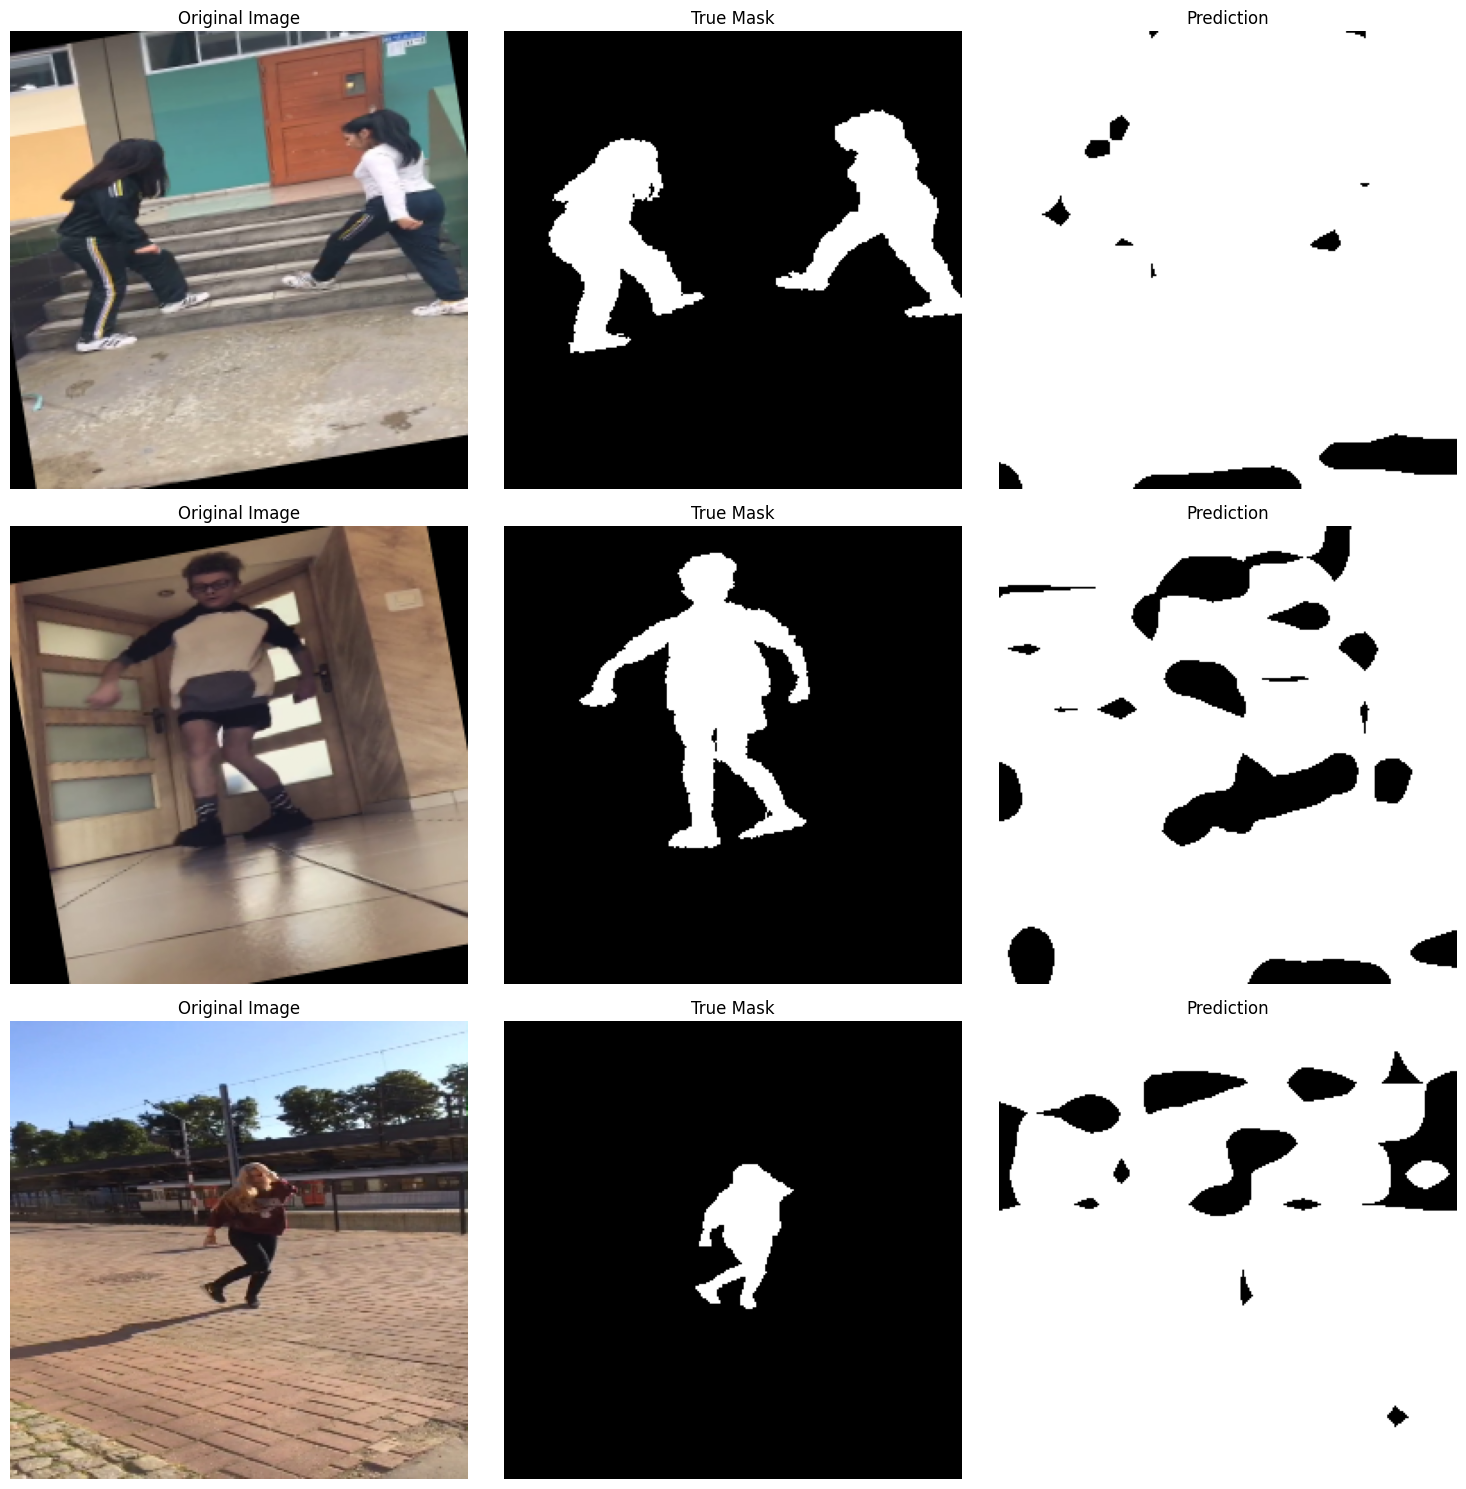

In [25]:
def show_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)

    plt.figure(figsize=(15, 5*num_samples))
    for i, idx in enumerate(indices, 1):
        image, mask = dataset[idx]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device)).squeeze().cpu().numpy()

        plt.subplot(num_samples, 3, 3*i-2)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i-1)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i)
        plt.imshow((pred > 0.5).astype(np.uint8), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(model, train_dataset)

Выводы
- В этот раз чуда не случилось, и трансформенные модели не смогли дообучиться. Возможно, они бы могли вырваться вперед, но я ограничен технологиями (нет видеокарты)
- В принципе сверточные модели себя хорошо показали
- Ресурсов гугл колаба не хватает(